In [1]:
import torch
from transformers import RobertaTokenizer
from torch.utils.data import Dataset
import multiprocessing as mp
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")

# Function to tokenize a single text
def tokenize_single(text, max_length=128, truncation=True):
    return tokenizer(
        text,
        add_special_tokens=True,
        padding="max_length",
        truncation=truncation,
        max_length=max_length
    )

# Custom Dataset for sarcasm detection with separate comment and context
class SarcasmDataset(Dataset):
    def __init__(self, comment_encodings, context_encodings, labels):
        self.comment_encodings = comment_encodings  # Dict with 'input_ids' and 'attention_mask' for comment
        self.context_encodings = context_encodings    # Dict with 'input_ids' and 'attention_mask' for context
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            "input_ids_comment": self.comment_encodings["input_ids"][idx],
            "attention_mask_comment": self.comment_encodings["attention_mask"][idx],
            "input_ids_context": self.context_encodings["input_ids"][idx],
            "attention_mask_context": self.context_encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Original dataset shape: (1010771, 3)


/tmp/ipykernel_19/2047336033.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_updated = df.groupby("label", group_keys=False).apply(


Balanced half dataset shape: (400000, 3)
Label distribution:
 label
0    200000
1    200000
Name: count, dtype: int64


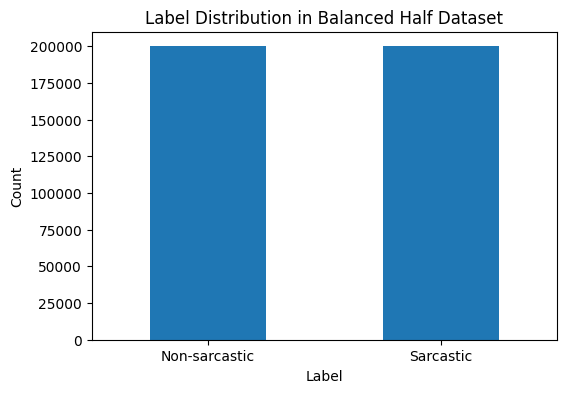

In [2]:
# Cell 1: Read and preprocess the dataset (balanced, half-sized) and visualize label distribution
import pandas as pd
import matplotlib.pyplot as plt

# Load the full dataset
file_path = "/kaggle/input/sarc-filtered/filtered_sarcasm_data.csv"
#file_path = "/kaggle/input/sarc-filtered-1000/sampled_sarcasm_data.csv"
df = pd.read_csv(file_path)
print("Original dataset shape:", df.shape)

# Sample 50% from each class to keep it balanced
df_updated = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(200000, random_state=42)
).reset_index(drop=True)

# Shuffle the balanced dataset
df_updated = df_updated.sample(frac=1, random_state=42).reset_index(drop=True)

# Show label distribution and shape
print("Balanced half dataset shape:", df_updated.shape)
print("Label distribution:\n", df_updated["label"].value_counts())

# Visualize label distribution
plt.figure(figsize=(6,4))
counts = df_updated["label"].value_counts()
counts.index = counts.index.map({0: "Non-sarcastic", 1: "Sarcastic"})
counts.sort_index().plot(kind='bar')
plt.title("Label Distribution in Balanced Half Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [3]:
# Suppose df_updated is your DataFrame with 'comment', 'context', and 'label' columns.
# Stratified train-test split to maintain label distribution
train_df, test_df = train_test_split(df_updated, test_size=0.2, random_state=42, stratify=df_updated["label"])

# Create list of comments and contexts separately
train_comments = train_df["comment"].tolist()
train_contexts = train_df["context"].tolist()
test_comments  = test_df["comment"].tolist()
test_contexts  = test_df["context"].tolist()

# Helper function for multiprocessing tokenization
def tokenize_wrapper(text):
    return tokenize_single(text)

# Use multiprocessing to tokenize comments and contexts separately
with mp.Pool(mp.cpu_count()) as pool:
    train_comment_tokenized = pool.map(tokenize_wrapper, train_comments)
    train_context_tokenized = pool.map(tokenize_wrapper, train_contexts)
    test_comment_tokenized  = pool.map(tokenize_wrapper, test_comments)
    test_context_tokenized  = pool.map(tokenize_wrapper, test_contexts)

# Convert tokenized outputs into PyTorch tensors for comments
train_input_ids_comment = torch.tensor([enc["input_ids"] for enc in train_comment_tokenized])
train_attention_mask_comment = torch.tensor([enc["attention_mask"] for enc in train_comment_tokenized])
train_comment_encodings = {"input_ids": train_input_ids_comment, "attention_mask": train_attention_mask_comment}

test_input_ids_comment = torch.tensor([enc["input_ids"] for enc in test_comment_tokenized])
test_attention_mask_comment = torch.tensor([enc["attention_mask"] for enc in test_comment_tokenized])
test_comment_encodings = {"input_ids": test_input_ids_comment, "attention_mask": test_attention_mask_comment}

# Convert tokenized outputs into PyTorch tensors for contexts
train_input_ids_context = torch.tensor([enc["input_ids"] for enc in train_context_tokenized])
train_attention_mask_context = torch.tensor([enc["attention_mask"] for enc in train_context_tokenized])
train_context_encodings = {"input_ids": train_input_ids_context, "attention_mask": train_attention_mask_context}

test_input_ids_context = torch.tensor([enc["input_ids"] for enc in test_context_tokenized])
test_attention_mask_context = torch.tensor([enc["attention_mask"] for enc in test_context_tokenized])
test_context_encodings = {"input_ids": test_input_ids_context, "attention_mask": test_attention_mask_context}

# Convert labels to tensors
train_labels = torch.tensor(train_df["label"].values, dtype=torch.long)
test_labels = torch.tensor(test_df["label"].values, dtype=torch.long)

# Create Dataset objects
train_dataset = SarcasmDataset(train_comment_encodings, train_context_encodings, train_labels)
test_dataset = SarcasmDataset(test_comment_encodings, test_context_encodings, test_labels)

print(f"Train dataset size: {len(train_dataset)} | Test dataset size: {len(test_dataset)}")


Train dataset size: 320000 | Test dataset size: 80000


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, RobertaTokenizer

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class CoAttentionSarcasmModel(nn.Module):
    def __init__(self, num_classes=2, share_encoder=True):
        super().__init__()
        # 1) Shared or separate encoders
        if share_encoder:
            self.comment_encoder = self.context_encoder = RobertaModel.from_pretrained("distilroberta-base")
        else:
            self.comment_encoder = RobertaModel.from_pretrained("distilroberta-base")
            self.context_encoder = RobertaModel.from_pretrained("distilroberta-base")

        
        # 2) Co‑attention layers
        self.comment_to_context_attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.context_to_comment_attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        
        # 3) Pooling & fusion
        self.attn_pool = nn.Linear(768, 1)
        self.layer_norm = nn.LayerNorm(768)
        self.dropout = nn.Dropout(0.3)
        
        # 4) Classification head
        self.mish = Mish()
        self.classifier = nn.Sequential(
            nn.Linear(768, 768),
            self.mish,
            nn.Dropout(0.3),
            nn.Linear(768, num_classes)
        )
    
    def forward(self,
                input_ids_comment, attention_mask_comment,
                input_ids_context, attention_mask_context):
        # Encode both sequences
        comment_out = self.comment_encoder(
            input_ids=input_ids_comment,
            attention_mask=attention_mask_comment
        ).last_hidden_state            # (B, Lc, 768)
        
        context_out = self.context_encoder(
            input_ids=input_ids_context,
            attention_mask=attention_mask_context
        ).last_hidden_state            # (B, Lx, 768)
        
        # Prepare masks for MultiheadAttention (True == ignore)
        ctx_key_padding = (attention_mask_context == 0)
        cmt_key_padding = (attention_mask_comment  == 0)
        
        # 1) Comment → Context
        c2x, _ = self.comment_to_context_attn(
            query=comment_out,
            key=context_out,
            value=context_out,
            key_padding_mask=ctx_key_padding
        )
        c2x = self.dropout(c2x)
        c2x = self.layer_norm(comment_out + c2x)  # skip connection
        
        # 2) Context → Comment
        x2c, _ = self.context_to_comment_attn(
            query=context_out,
            key=comment_out,
            value=comment_out,
            key_padding_mask=cmt_key_padding
        )
        x2c = self.dropout(x2c)
        x2c = self.layer_norm(context_out + x2c)  # skip connection
        
        # 3) Attention pooling on both updated sequences
        # Comment pooled
        scores_c = self.attn_pool(c2x).squeeze(-1)                    # (B, Lc)
        scores_c = scores_c.masked_fill(attention_mask_comment==0, -1e9)
        weights_c = F.softmax(scores_c, dim=1).unsqueeze(-1)          # (B, Lc,1)
        pooled_c = torch.sum(c2x * weights_c, dim=1)                  # (B, 768)
        
        # Context pooled
        scores_x = self.attn_pool(x2c).squeeze(-1)                    # (B, Lx)
        scores_x = scores_x.masked_fill(attention_mask_context==0, -1e9)
        weights_x = F.softmax(scores_x, dim=1).unsqueeze(-1)          # (B, Lx,1)
        pooled_x = torch.sum(x2c * weights_x, dim=1)                  # (B, 768)
        
        # 4) Fuse and classify
        fused = self.layer_norm(pooled_c + pooled_x)                  # (B, 768)
        logits = self.classifier(fused)                               # (B, num_classes)
        return logits

# Example instantiation:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoAttentionSarcasmModel(num_classes=2, share_encoder=True).to(device)
print(model)


2025-04-18 21:37:32.314273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745012252.562179      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745012252.633007      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

CoAttentionSarcasmModel(
  (comment_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [5]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        # Use the separate keys for comment and context inputs
        input_ids_comment = batch["input_ids_comment"].to(device)
        attention_mask_comment = batch["attention_mask_comment"].to(device)
        input_ids_context = batch["input_ids_context"].to(device)
        attention_mask_context = batch["attention_mask_context"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids_comment, attention_mask_comment, input_ids_context, attention_mask_context)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Use the separate keys for comment and context inputs
            input_ids_comment = batch["input_ids_comment"].to(device)
            attention_mask_comment = batch["attention_mask_comment"].to(device)
            input_ids_context = batch["input_ids_context"].to(device)
            attention_mask_context = batch["attention_mask_context"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids_comment, attention_mask_comment, input_ids_context, attention_mask_context)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    return avg_loss, all_preds, all_labels


Epoch 1/5


Evaluating: 100%|██████████| 1250/1250 [10:16<00:00,  2.03it/s]


Train Loss: 0.5282 | Val Loss: 0.4917

Epoch 2/5


Evaluating: 100%|██████████| 1250/1250 [10:24<00:00,  2.00it/s]


Train Loss: 0.4742 | Val Loss: 0.4775

Epoch 3/5


Evaluating: 100%|██████████| 1250/1250 [10:27<00:00,  1.99it/s]


Train Loss: 0.4416 | Val Loss: 0.4789

Epoch 4/5


Evaluating: 100%|██████████| 1250/1250 [10:28<00:00,  1.99it/s]


Train Loss: 0.4097 | Val Loss: 0.4865

Epoch 5/5


Evaluating: 100%|██████████| 1250/1250 [10:27<00:00,  1.99it/s]

Train Loss: 0.3767 | Val Loss: 0.4981



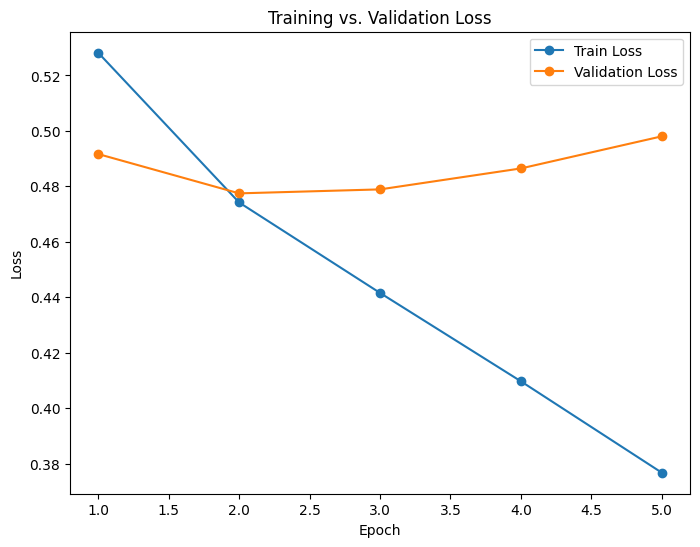

Test Accuracy: 77.48%


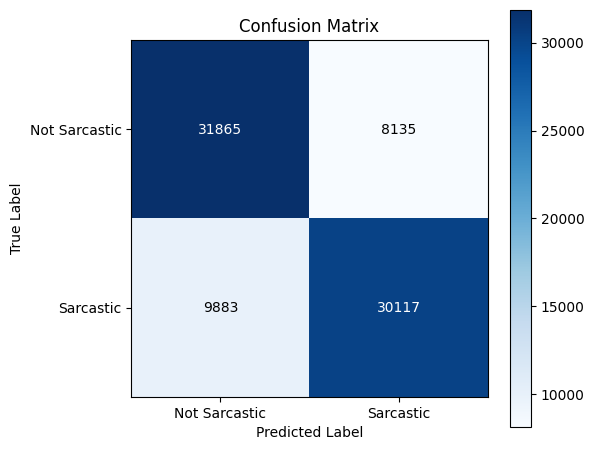

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_preds, val_labels = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}\n")

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# Compute accuracy on the test set
accuracy = accuracy_score(val_labels, val_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = ['Not Sarcastic', 'Sarcastic']
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [7]:
# Save the model's state dictionary to a file
MODEL_PATH = "/kaggle/working/sarcasm_model_co.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /kaggle/working/sarcasm_model_co.pth
